# Population Stability Index (PSI)

- skip_exec: true


PSI is a measure of how much a population has shifted over time or between two different samples of a population in a single number. It does this by binning the two distributions and comparing the proportion of items in each bin. This results in a single number you can use to understand how different the populations are.


In [ ]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from fastai.tabular.all import add_datepart, cont_cat_split, TabularPandas, Categorify, FillMissing

pd.set_option("display.max_columns", None)

plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0


## Example


We'll train a model on the Blue Book for Bulldozers dataset. The training set for this is the data from before October 2011 and the validation set is everything after that. The PSI score will help us understand if the population has shifted between the two sets.


In [ ]:
df = pd.read_csv(f"../data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])


In [ ]:
df["SalePrice"] = np.log(df["SalePrice"])


In [ ]:
df = add_datepart(df, "saledate", drop=False)


In [ ]:
df["ProductSize"] = df["ProductSize"].astype("category")
df["ProductSize"] = df["ProductSize"].cat.set_categories(
    ["Compact", "Mini", "Small", "Medium", "Large / Medium", "Large"], ordered=True
)

df["UsageBand"] = df["UsageBand"].astype("category")
df["UsageBand"] = df["UsageBand"].cat.set_categories(["Low", "Medium", "High"], ordered=True)


In [ ]:
conts, cats = cont_cat_split(df.drop(columns=["saledate"]), max_card=20, dep_var="SalePrice")


In [ ]:
procs = [Categorify, FillMissing]


In [ ]:
cond = (df["saleYear"] < 2011) | (df["saleMonth"] < 10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx), list(valid_idx))


In [ ]:
to = TabularPandas(df.drop(columns=["saledate"]), procs, cats, conts, y_names="SalePrice", splits=splits)


In [ ]:
len(conts), len(cats)


(11, 55)

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(np.array(to.train.xs), np.array(to.train.y))


RandomForestRegressor(n_jobs=-1)

In [ ]:
print(m.score(np.array(to.train.xs), np.array(to.train.y)))
print(m.score(np.array(to.valid.xs), np.array(to.valid.y)))


0.9881219285666549
0.8943878785209834


In [ ]:
train_preds = m.predict(np.array(to.train.xs))
valid_preds = m.predict(np.array(to.valid.xs))


In [ ]:
train_preds.min(), train_preds.max(), train_preds.mean()


(8.490840711593627, 11.847966022491455, 10.104334967219676)

## PSI


We calculate the PSI like this:

1. Take two distributions, the reference and the target
2. Create `n_bins` number of bins

   - If the `bin_mode` is `fixed` then the bins are created with equal width (the delta between the min and max value in each bin is the same)
   - If the `bin_mode` is `quantile` then the bins are created so an equal number of items fall into each bin

   Note that the bins are created for the reference distribution and then applied to the target distribution

3. Calculate the proportion of items in each bin for the reference and target distributions
4. Add a small value `epsilon` to any proportions with a value of 0 to avoid dividing by or taking the log of 0 in PSI formula
5. Calculate the PSI. The formula is:

   $$
   PSI = \sum_{b=1}^{B}((\text{TargetProp($b$)} - \text{RefProp($b$)})) \times \ln(\frac{\text{TargetProp($b$)}}{\text{RefProp($b$)}})
   $$

   $\text{RefProp(b)}$ = Proportionof counts within bin $b$ from the reference distribution\
   $\text{TargetProp(b)}$ = Proportion of counts within bin $b$ from the target distribution\
   $\text{B}$ = Number of bins


In [ ]:
def get_population_proportions(
    ref: np.ndarray, target: np.ndarray, n_bins: int, bin_mode: str, eps: float = 0.001
) -> Tuple[np.ndarray, np.ndarray]:
    if bin_mode == "fixed":
        ref_counts, breakpoints = np.histogram(ref, n_bins)
    elif bin_mode == "quantile":
        breakpoints = np.quantile(ref, np.arange(0, n_bins + 1) / (n_bins) * 100 / 100)
        ref_counts = np.histogram(ref, breakpoints)[0]

    target_counts = np.histogram(target, breakpoints)[0]

    ref_proportions = ref_counts / ref_counts.sum()
    target_proportions = target_counts / target_counts.sum()

    ref_proportions = np.where(ref_proportions == 0, eps, ref_proportions)
    target_proportions = np.where(target_proportions == 0, eps, target_proportions)

    return ref_proportions, target_proportions


In [ ]:
def psi(ref: np.ndarray, target: np.ndarray, n_bins: int, bin_mode: str, eps: float = 0.001) -> float:
    ref_proportions, target_proportions = get_population_proportions(ref, target, n_bins, bin_mode, eps)
    psi = np.sum((target_proportions - ref_proportions) * np.log(target_proportions / ref_proportions))
    return psi


In [ ]:
psi(train_preds, valid_preds, 10, "fixed")


0.05345701915243874

In [ ]:
psi(train_preds, valid_preds, 10, "quantile")


0.05602506051260836

When it comes to interpreting the PSI score, the general rule of thumb is that:

- PSI < 0.1: no significant population change
- PSI < 0.2: moderate population change
- PSI >= 0.2: significant population change

In the case of our example it looks there isn't any significant population change between the training and validation sets.


## Visualising PSI


Plotting the proportions in each bin can help us see how the two distributions vary.


In [ ]:
def plot_bin_proportions(ref: np.ndarray, target: np.ndarray, n_bins: int, bin_mode: str, eps: float = 0.001):
    ref_proportions, target_proportions = get_population_proportions(ref, target, n_bins, bin_mode, eps)
    fig, ax = plt.subplots(figsize=(10, 5))
    df = pd.DataFrame({"ref": ref_proportions, "target": target_proportions, "bin": range(n_bins)})
    df.plot.bar(x="bin", ax=ax)
    ax.set_title(f"Bin Proportions ({bin_mode} binning)")
    ax.set_xlabel("Bin")
    ax.set_ylabel("Proportion")
    ax.legend(["Reference", "Target"])
    plt.show()


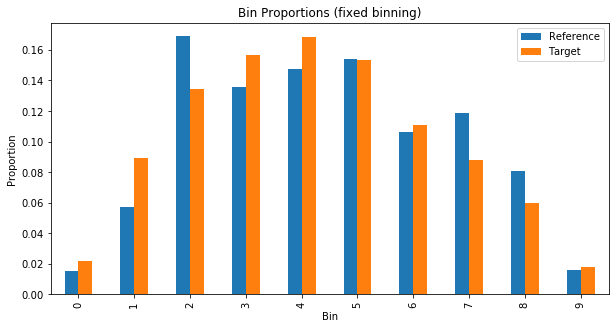

In [ ]:
plot_bin_proportions(valid_preds, train_preds, 10, "fixed")


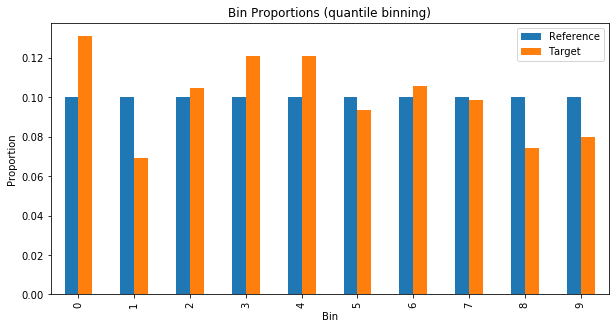

In [ ]:
plot_bin_proportions(valid_preds, train_preds, 10, "quantile")


We can see something similar without resorting to binning by creating a kernel density estimate (KDE) plot. This represents the data using a continuous probability density curve in one or more dimensions. To quote the Seaborn documentation:

> _"Relative to a histogram, KDE can produce a plot that is less cluttered and more interpretable, especially when drawing multiple distributions. But it has the potential to introduce distortions if the underlying distribution is bounded or not smooth. Like a histogram, the quality of the representation also depends on the selection of good smoothing parameters."_


In [ ]:
def plot_densities(ref: np.ndarray, target: np.ndarray, figsize: Tuple[int, int] = None):
    fig, ax = plt.subplots(figsize=figsize)
    sns.kdeplot(ref, shade=True, label="Initial", ax=ax)
    sns.kdeplot(target, shade=True, label="New", ax=ax)
    ax.set_title("KDE of Predicted Probabilities")
    ax.set_xlabel("Predicted Sale Price")
    ax.legend(["Reference", "Target"])
    plt.show()


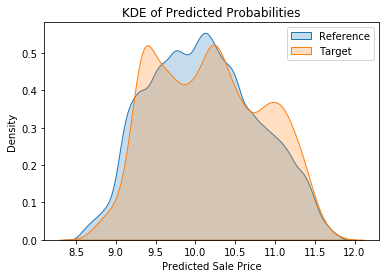

In [ ]:
plot_densities(train_preds, valid_preds)


## Feature Stability Importance (FSI)


Feature (also known as Characteristic) Stability Importance (FSI) is a measure of how much a feature varies between two distributions. It is calculated by taking the PSI score for each feature and then normalising it by the PSI score for the whole dataset. This results in a single number for each feature that can be used to understand how stable the feature is.


In [ ]:
def fsi(
    ref_df: pd.DataFrame, target_df: pd.DataFrame, features: List[str], n_bins: int, bin_mode: str
) -> pd.DataFrame:
    df = pd.DataFrame(columns=["feature", "fsi"])
    for col in features:
        csi_values = psi(ref_df[col].values, target_df[col].values, n_bins, bin_mode)
        csi = np.mean(csi_values)
        df = pd.concat([df, pd.DataFrame({"feature": [col], "fsi": [csi]})], ignore_index=True)
    df = df.sort_values("fsi", ascending=False)
    return df


In [ ]:
sorted_fsis = fsi(to.train.xs, to.valid.xs, to.train.xs.columns, 10, "quantile").sort_values("fsi", ascending=False)
sorted_fsis


,feature,fsi
65,saleElapsed,6.163579
55,SalesID,5.589695
0,datasource,5.385627
61,saleYear,5.104866
45,saleMonth,4.977286
...,...,...
53,auctioneerID_na,0.000000
51,saleIs_year_end,0.000000
50,saleIs_quarter_start,0.000000
49,saleIs_quarter_end,0.000000


It's often easy to see why some features drift a great deal between different populations. For instance anything to do with time given how we split our data. But other features may not be so obvious. Making KDE plots for each feature can help us interpret the FSI scores.


In [ ]:
def plot_fsi(ref_df: pd.DataFrame, target_df: pd.DataFrame, features: List[str], n_cols: int = 5):
    n_rows = int(np.ceil(len(features) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    for feature, ax in zip(features, axes.ravel()):
        sns.kdeplot(ref_df[feature], label="Reference", shade=True, ax=ax)
        sns.kdeplot(target_df[feature], label="Target", shade=True, ax=ax)
        ax.set_title(feature)
        ax.legend()
    plt.tight_layout()
    plt.show()


/Users/henrydashwood/.pyenv/versions/3.10.3/envs/py3103/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/henrydashwood/.pyenv/versions/3.10.3/envs/py3103/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/henrydashwood/.pyenv/versions/3.10.3/envs/py3103/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/henrydashwood/.pyenv/versions/3.10.3/envs/py3103/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False`

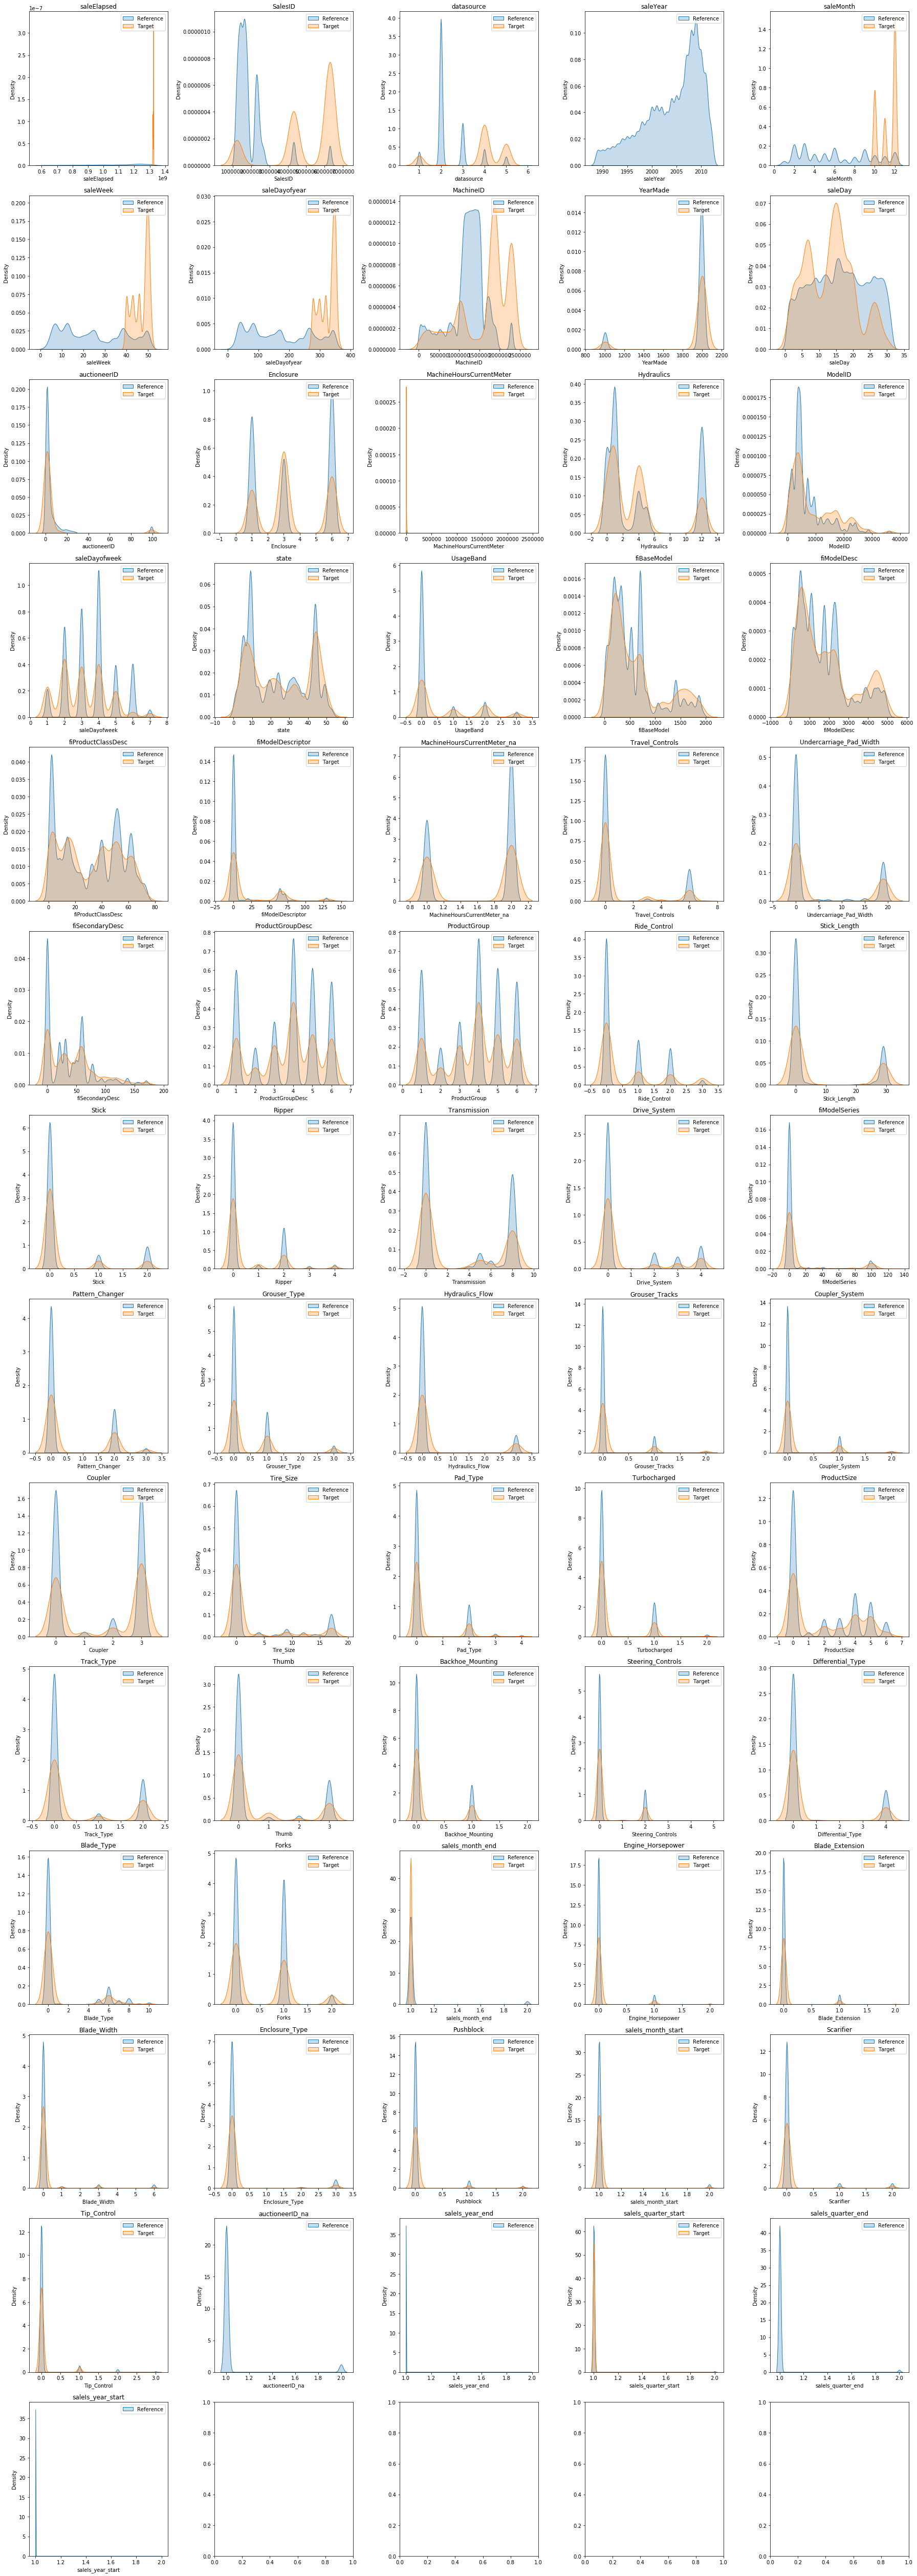

In [ ]:
plot_fsi(to.train.xs, to.valid.xs, sorted_fsis["feature"].values)


## References


The following resources were useful in introducing me to the concept of PSI and clarifying my thinking:

- [Is your ML model stable? Checking model stability and population drift with PSI and CSI](https://towardsdatascience.com/checking-model-stability-and-population-shift-with-psi-and-csi-6d12af008783) - Vinícius Trevisan
- [Population Stability Index](https://mwburke.github.io/data%20science/2018/04/29/population-stability-index.html) - Matthew Burke
- [Measuring Data Drift: Population Stability Index](https://www.fiddler.ai/blog/measuring-data-drift-population-stability-index) - Murtuza Shergadwala

The example model is used in the [FastAI book](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb) and at least two of the Fast AI courses.
